# Exploration of Gaussian processes



In [8]:
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

rng = np.random.RandomState(0)


https://en.wikipedia.org/wiki/Radial_basis_function_kernel

$$
K(\mathbf {x} ,\mathbf {x'} )=\exp \left(-{\frac {\|\mathbf {x} -\mathbf {x'} \|^{2}}{2\sigma ^{2}}}\right)
$$


In [2]:
def rbf_kernel(X1, X2, length_scale=1.0, variance=1.0):
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return variance * np.exp(-0.5 / length_scale**2 * sqdist)


In [15]:
print(rbf_kernel(X1=np.array([[1, 2]]), X2=np.array([[1, 2]])))
print(rbf_kernel(X1=np.array([[0, 0]]), X2=np.array([[0, 1]])))
print(rbf_kernel(X1=np.array([[0, 0]]), X2=np.array([[1, 1]])))

[[1.]]
[[0.60653066]]
[[0.36787944]]


In [3]:
class GaussianProcessRegressor:
    def __init__(self, kernel, noise=1e-10):
        self.kernel = kernel
        self.noise = noise
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.K = self.kernel(X_train, X_train) + self.noise * np.eye(len(X_train))
        self.L = np.linalg.cholesky(self.K)
        self.alpha = np.linalg.solve(self.L.T, np.linalg.solve(self.L, y_train))
    
    def predict(self, X_test):
        K_s = self.kernel(self.X_train, X_test)
        K_ss = self.kernel(X_test, X_test) + self.noise * np.eye(len(X_test))
        
        # Mean of the predictive distribution
        mu_s = K_s.T.dot(self.alpha)
        
        # Covariance of the predictive distribution
        v = np.linalg.solve(self.L, K_s)
        cov_s = K_ss - v.T.dot(v)
        
        return mu_s, cov_s


In [4]:
X_train = np.random.uniform(-5, 5, 10).reshape(-1, 1)
y_train = np.sin(X_train) + 0.1 * np.random.randn(10, 1)

X_test = np.linspace(-5, 5, 100).reshape(-1, 1)


In [5]:
gp = GaussianProcessRegressor(kernel=rbf_kernel)
gp.fit(X_train, y_train)


In [6]:
mu_s, cov_s = gp.predict(X_test)
std_s = np.sqrt(np.diag(cov_s))


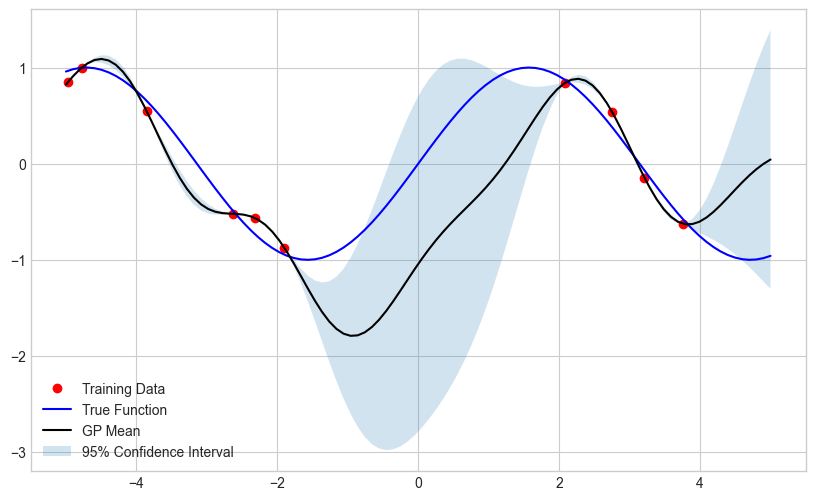

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(X_train, y_train, 'ro', label='Training Data')
plt.plot(X_test, np.sin(X_test), 'b-', label='True Function')
plt.plot(X_test, mu_s, 'k-', label='GP Mean')
plt.fill_between(X_test.ravel(), mu_s.ravel() - 1.96 * std_s, mu_s.ravel() + 1.96 * std_s, alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.show()
